In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

In [2]:
# Network Parameters
num_input = 6
timesteps = 80 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [3]:
#iPhoneSensors_T1_ID1_1L_GD.csv
with open("weallwalk/sensor/iPhoneSensors_T1_ID1_1L_GD.csv", "r") as csvfile:
    reader = csv.reader(csvfile) # 读取csv文件，返回的是迭代类型
    dataset = [row[17:23] for row in reader]
    print(len(dataset))
    print(dataset[:10])


2222
[['-0.019518', '0.008494', '-0.028465', '-0.005996', '0.020669', '-0.004296'], ['-0.005692', '0.000057', '-0.024276', '-0.000256', '0.014950', '0.001150'], ['0.007102', '0.005360', '-0.023330', '0.004456', '0.016611', '-0.002063'], ['-0.000434', '0.001039', '-0.028566', '0.006550', '0.017119', '-0.000400'], ['-0.001535', '-0.011660', '-0.027445', '0.005630', '0.018032', '0.000301'], ['0.003800', '-0.013711', '-0.020021', '0.005064', '0.016065', '-0.000907'], ['-0.015345', '-0.009429', '-0.015628', '0.004625', '0.014716', '-0.003756'], ['-0.015340', '-0.008360', '-0.014566', '0.002188', '0.016319', '0.000343'], ['-0.006906', '-0.021035', '-0.006022', '0.004755', '0.016605', '0.004856'], ['-0.000459', '-0.003021', '-0.005078', '0.007958', '0.009406', '-0.000746']]


In [4]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile) # 读取csv文件，返回的是迭代类型
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])
#     print(strike_times[-10:])
#     print(len(strike_times))

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction
#     print(all_info)
    
#     p_dir = re.compile(r'<Direction>(.*?)</Direction>')
#     all_dir = p_dir.findall(cts)
#     print(all_dir)

#     p_starttime = re.compile(r'<StartTime>(.*?)</StartTime>')
#     all_starttime = p_starttime.findall(cts)
#     print(all_starttime)

#     p_endtime = re.compile(r'<EndTime>(.*?)</EndTime>')
#     all_endtime = p_endtime.findall(cts)
#     print(all_endtime)

    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]

#     print(len(window_y))  
    return window_y

2750
2750


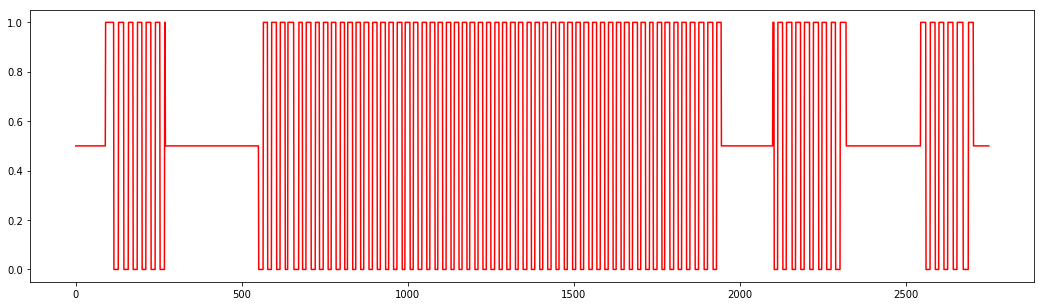

In [5]:
data_x_2 = read_sensor("weallwalk/sensor/iPhoneSensors_T2_ID1_1L_GD.csv")
print(len(data_x_2))

data_y_2 = read_xml("weallwalk/xml/T2_ID1_GD.xml", len(data_x_2))
print(len(data_y_2))

plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in data_y_2], 'r')
plt.show()

In [7]:
print(len(data_x_2), len(data_y_2))

data_x2_seq, data_y2_seq = [], []
for i in range(len(data_x_2)-timesteps):
    flag=1
    for iy in data_y_2[i:i+timesteps]:
#         print(iy)
        if(iy[0]==0.5):
#             print(0.5)
            flag=0
            break
    if(flag==1):  
        x=data_x_2[i:i+timesteps]
        y=data_y_2[i+timesteps]
        data_x2_seq.append(x)
        data_y2_seq.append(y)

print(len(data_x2_seq), len(data_y2_seq))

(2750, 2750)
(1637, 1637)


In [8]:
order = list(range(0,len(data_x2_seq),1))
random.shuffle(order)

train_x = [data_x2_seq[i] for i in order]
train_y = [data_y2_seq[i] for i in order]

print(len(train_x))

1637


In [9]:
order = list(range(0,len(data_x2_seq),1))
random.shuffle(order)

train_x = [data_x2_seq[i] for i in order]
train_y = [data_y2_seq[i] for i in order]

print(len(train_x))

1637


In [10]:
data_x_1 = read_sensor("weallwalk/sensor/iPhoneSensors_T1_ID1_1L_GD.csv")
print(len(data_x_1))

data_y_1 = read_xml("weallwalk/xml/T1_ID1_GD.xml", len(data_x_1))
print(len(data_y_1))

2222
2222


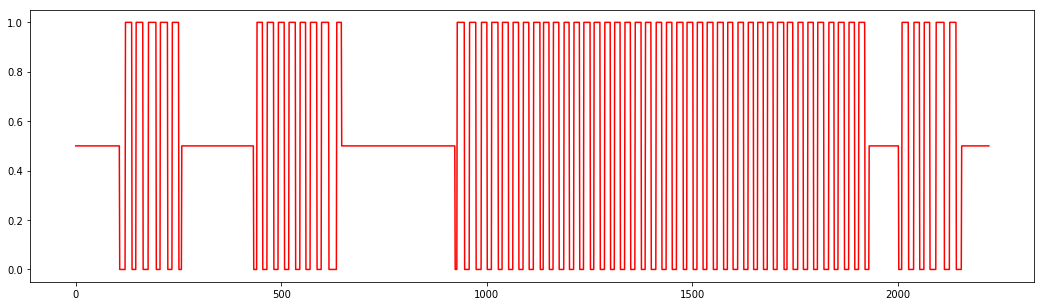

In [11]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in data_y_1], 'r')
plt.show()

In [12]:
print(len(data_x_1), len(data_y_1))

data_x1_seq, data_y1_seq = [], []
for i in range(len(data_x_1)-timesteps):
    flag=1
    for iy in data_y_1[i:i+timesteps]:
#         print(iy)
        if(iy[0]==0.5):
#             print(0.5)
            flag=0
            break
    if(flag==1):  
        x=data_x_1[i:i+timesteps]
        y=data_y_1[i+timesteps]
        data_x1_seq.append(x)
        data_y1_seq.append(y)

print(len(data_x1_seq), len(data_y1_seq))

(2222, 2222)
(1209, 1209)


In [13]:
test_x = data_x1_seq
test_y = data_y1_seq

print(len(test_x))

1209


In [14]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
    return lstm_cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
        #'out':tf.Variable(tf.zeros([1]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

In [15]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
print(train_length)

train_x_extend = [i for i in train_x]
train_y_extend = [i for i in train_y]

print(len(train_x_extend))

1637
1637


In [16]:
if(len(train_x_extend)==len(train_x)):
    train_x_extend.extend(train_x[0:batch_size])
    train_y_extend.extend(train_y[0:batch_size])
print(len(train_x_extend))

1893


In [63]:
def cal_accuarcy(y, _y):
    count = 0
    for i in range(0, len(y)):
        if(y[i][0] == round(_y[i][0])):
            count += 1;
    return count*1.0/len(y)
#     print("train accuarcy : ", count/len(y))

In [64]:
training_steps = 1001

config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allocator_type = 'BFC'
# config.gpu_options.per_process_gpu_memory_fraction = 0.40
with tf.Session(graph=graph, config=config) as session:
    saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#     saver.restore(session, "lstm_check/my-model-gpu-batch-test-add-data.ckpt-10000")
#     tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
        if (step % 200 == 0):
            train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
            print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
            #train accuarcy
        if (step % 500 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-error-metric.ckpt', global_step=step+1500)
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
#     train_loss, train_logits = session.run([loss,logits], feed_dict={X: train_x, Y: train_y})
    test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})

INFO:tensorflow:Restoring parameters from lstm_check/my-model-gpu-error-metric.ckpt-1500
Initialized
Loss at step 0: 0.000471, train accuarcy : 1.000000
Loss at step 200: 0.011295, train accuarcy : 0.988281
Loss at step 400: 0.000680, train accuarcy : 0.992188
Loss at step 600: 0.000813, train accuarcy : 1.000000
Loss at step 800: 0.001519, train accuarcy : 1.000000
Loss at step 1000: 0.000316, train accuarcy : 1.000000


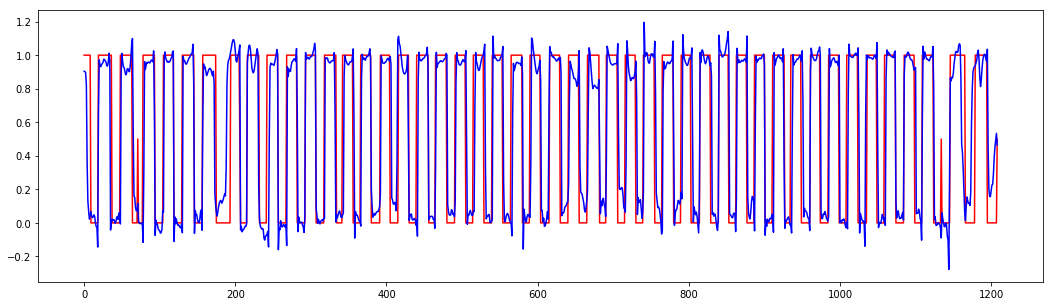

In [23]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y], 'r')
plt.plot([i[0] for i in test_logits], 'b')
plt.show()

In [27]:
# print(test_y)
print(test_logits)

[[ 0.90409255]
 [ 0.90192258]
 [ 0.8961122 ]
 ..., 
 [ 0.49491799]
 [ 0.53353417]
 [ 0.46380115]]


In [33]:
print("test loss : ", test_loss)

count = 0
for i in range(0, len(test_x)):
    #if(test_y[i][0]-test_y[i-1][0]>0.9):
#     print(test_y[i][0], test_logits[i][0])
    if(test_y[i][0] == round(test_logits[i][0])):
#         print('same')
        count += 1;
print(count)
print(len(test_x))
print("test accuarcy : ", count*1.0/len(test_x))

('test loss : ', 0.091568552)
1085
1209
('test accuarcy : ', 0.8974358974358975)


In [58]:
#test_y      [[0], [0], [1]]
#test_logits 

step_time_actual = []
step_time_predict = []
for i in range(1, len(test_y)):
    if(abs(test_y[i][0]-test_y[i-1][0])>0.5):
        step_time_actual.append(i)
    if(abs(test_logits[i][0]-test_logits[i-1][0])>0.5):
        step_time_predict.append(i)

print(len(step_time_actual))   
print(len(step_time_predict))

92
89


In [59]:
print(zip(step_time_actual, step_time_predict))

print(step_time_actual)
print(step_time_predict)

[(9, 19), (19, 35), (37, 49), (48, 65), (64, 80), (78, 94), (94, 106), (105, 119), (119, 131), (130, 146), (146, 157), (157, 173), (175, 207), (194, 216), (216, 231), (232, 245), (242, 257), (257, 269), (268, 283), (282, 293), (293, 307), (307, 319), (318, 333), (334, 344), (342, 358), (356, 367), (366, 380), (380, 393), (392, 407), (405, 415), (416, 430), (430, 442), (440, 456), (456, 466), (465, 481), (480, 492), (491, 507), (505, 517), (515, 531), (529, 541), (540, 555), (554, 567), (565, 581), (580, 592), (590, 605), (604, 615), (616, 632), (630, 656), (641, 692), (655, 707), (666, 718), (682, 732), (691, 741), (706, 757), (716, 766), (730, 780), (740, 781), (755, 792), (765, 805), (780, 806), (790, 815), (803, 831), (815, 840), (829, 854), (840, 864), (853, 878), (863, 888), (877, 901), (887, 913), (901, 926), (911, 937), (927, 952), (935, 961), (949, 975), (961, 986), (974, 1000), (985, 1011), (999, 1026), (1009, 1034), (1024, 1050), (1036, 1061), (1049, 1074), (1059, 1085), (107

In [62]:
step_count = len(step_time_actual)
undercount = 0
overcount = 0

for i in range(1, step_count):
    gap_count = [t for t in step_time_predict if t>=step_time_actual[i-1] and t<step_time_actual[i]]
#     print(gap_count)
    if(len(gap_count)>1):
        overcount += len(gap_count)-1
    if(len(gap_count)<1):
        undercount += 1

print(undercount)
print(overcount)
print('undercount : ', undercount*1.0/step_count)
print('overcount : ', overcount*1.0/step_count)
print('segement undercount : ', 1-len(step_time_predict)*1.0/len(step_time_actual))

14
11
('undercount : ', 0.15217391304347827)
('overcount : ', 0.11956521739130435)
('segement undercount : ', 0.03260869565217395)
